In [1]:
%matplotlib inline

import os
import numpy as np
import glob
import pickle
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from astropy.io import fits

import lsst.afw.image as afwImage
import lsst.afw.math as afwMath

from lsst.eotest.sensor.MaskedCCD import MaskedCCD
from lsst.eotest.sensor.AmplifierGeometry import parse_geom_kwd
import lsst.eotest.sensor as sensorTest
import lsst.eotest.image_utils as imutils
from lsst.eotest.sensor.flatPairTask import find_flat2    # for use with TS8 data in the flat_pairs and ptc tasks

In [2]:
# Specify a raft and a run to analyze.
root_dir = '/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_archive/LCA-11021_RTM/'
raft = 'LCA-11021_RTM-012'
run = '11067'
slots = ['S00','S01','S02','S10','S11','S12','S20','S21','S22']

# A function to help gather the data.
def glob_files(*args):
    return sorted(glob.glob(os.path.join(root_dir,raft,run,*args)))


# Get Dictionary of Images files for BIAS and FLAT, for wavelengths 620,750,870nm keyed by Slot
bias_files = {}
flat620_files = {}
flat750_files = {}
flat870_files = {}

for slot in slots:
    bias_files[slot] = glob_files('qe_raft_acq/v0/*',slot,'*lambda_bias*')
    flat620_files[slot] = glob_files('qe_raft_acq/v0/*',slot,'*lambda_flat_0620*')
    flat750_files[slot] = glob_files('qe_raft_acq/v0/*',slot,'*lambda_flat_0750*')
    flat870_files[slot] = glob_files('qe_raft_acq/v0/*',slot,'*lambda_flat_0870*')




In [11]:
# make median of the BIAS files
for slot in slots:
    print(slot)

    # Create a superBIAS image to use with MaskedCCD
    bias_frame = '{}_{}_{}_superbias.fits'.format(raft,run,slot)
    amp_geom = sensorTest.makeAmplifierGeometry(bias_files[slot][0])
    superbias_file = imutils.superbias_file(bias_files[slot], amp_geom.serial_overscan, bias_frame)  



S00
S01
S02
S10
S11
S12
S20
S21
S22


In [3]:
# Get CCDids for each slot
ccdid = {}
for slot in slots:
    ccdid[slot] = os.path.split(flat750_files['S00'][0])[-1][0:14]
print(ccdid)

{'S00': 'E2V-CCD250-237', 'S01': 'E2V-CCD250-237', 'S02': 'E2V-CCD250-237', 'S10': 'E2V-CCD250-237', 'S11': 'E2V-CCD250-237', 'S12': 'E2V-CCD250-237', 'S20': 'E2V-CCD250-237', 'S21': 'E2V-CCD250-237', 'S22': 'E2V-CCD250-237'}


In [4]:
# get original Fe55 Gain results
orig_result_files = {slot: glob_files('fe55_raft_analysis', 'v0', '*','{}_eotest_results.fits'.format(ccdid[slot]))
                    for slot in slots}
                 
orig_gains = {}
for slot in slots:
    orig_eotest_results = sensorTest.EOTestResults(orig_result_files[slot][0])
    orig_gains[slot] = {amp: gain for amp, gain in zip(orig_eotest_results['AMP'], orig_eotest_results['GAIN'])}
    
print(orig_gains['S00'])

{1: 79.0669, 2: 1.1335409, 3: 1.1237552, 4: 1.1181288, 5: 1.116672, 6: 1.1215564, 7: 1.1236247, 8: 1.130451, 9: 1.147309, 10: 1.1422157, 11: 1.1531779, 12: 1.1464696, 13: 1.1494925, 14: 1.1517358, 15: 1.1411655, 16: 1.125567}


In [5]:
# BIAS and GAIN correct Images, and write out corrected FLAT fields 
for slot in slots:
    print(slot,)

    bias_frame = '{}_{}_{}_superbias.fits'.format(raft,run,slot)
    flat620 = sensorTest.MaskedCCD(flat620_files[slot][0], bias_frame=bias_frame)
    flat750 = sensorTest.MaskedCCD(flat750_files[slot][0], bias_frame=bias_frame)
    flat870 = sensorTest.MaskedCCD(flat870_files[slot][0], bias_frame=bias_frame)

    # Write out the gain-corrected pixel data as an MEF.
    flat620_frame = '{}_{}_{}_flat620.fits'.format(raft,run,slot)
    flat620.write_bias_subtracted_MEF(flat620_frame,gains=orig_gains[slot])
    
    flat750_frame = '{}_{}_{}_flat750.fits'.format(raft,run,slot)
    flat750.write_bias_subtracted_MEF(flat750_frame,gains=orig_gains[slot])
    
    flat870_frame = '{}_{}_{}_flat870.fits'.format(raft,run,slot)
    flat870.write_bias_subtracted_MEF(flat870_frame,gains=orig_gains[slot])




S00
S01
S02
S10
S11
S12
S20
S21
S22


In [26]:
# read back in corrected images
slot = 'S11'
flat620_frame = '{}_{}_{}_flat620.fits'.format(raft,run,slot)
flat750_frame = '{}_{}_{}_flat750.fits'.format(raft,run,slot)
flat870_frame = '{}_{}_{}_flat870.fits'.format(raft,run,slot)
flat620 = sensorTest.MaskedCCD(flat750_frame)
flat750 = sensorTest.MaskedCCD(flat750_frame)
flat870 = sensorTest.MaskedCCD(flat870_frame)

# imaging section of each amplifier (same for all images)
imaging = flat620.amp_geom.imaging

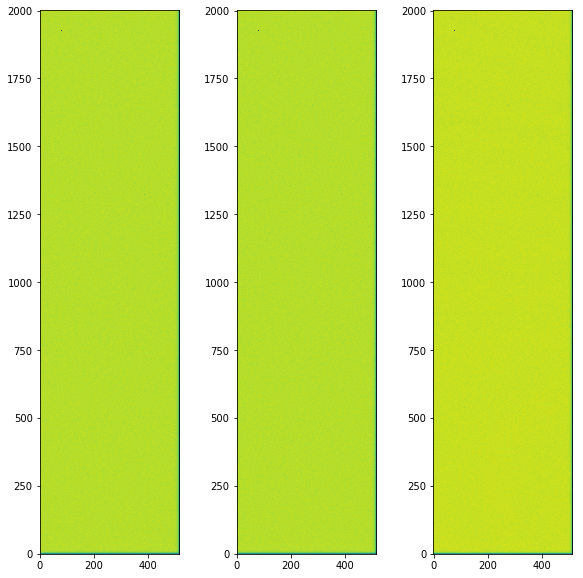

In [33]:
# plot images of one amplifier for each wavelength
f,ax = plt.subplots(1,3,figsize=(10,10))

flat620_amp1trim = imutils.trim(flat620[1], imaging)
flat750_amp1trim = imutils.trim(flat750[1], imaging)
flat870_amp1trim = imutils.trim(flat870[1], imaging)

ax[0].imshow(flat620_amp1trim.getImage().getArray(),origin='lower',interpolation='None')
ax[1].imshow(flat750_amp1trim.getImage().getArray(),origin='lower',interpolation='None')
ax[2].imshow(flat870_amp1trim.getImage().getArray(),origin='lower',interpolation='None')


